# Housing Price Predictor
&nbsp;&nbsp;&nbsp;&nbsp;_by Roy Li (tianqil1) and Alvin Shi (xiangs1)_

## Introduction:

Housing is something that everyone needs and houses come at a high cost. While it is possible to hire real estate agents to look for houses for you, it can often cost tens of thousands of dollars, money that could be spent on buying an even better house. 

For our final project, we wanted to collect and analyze existing house data and ultimately build a tool that can predict the price of a house given some features of the house. Initially, we wanted to be able to predict house prices anywhere in the U.S. However, due to some constraints we will explain in more detail below, we have narrowed our project down to predicting house prices in Pittsburgh.

### Initial Idea

When we first thought of the project, we decided that there are two major components to the success of this project:
1. Finding appropriate features and collecting those data, and
2. Coming up with a good model that will give the highest accuracy.

For the features, after much brainstorming, we decided that these aspects would have the greatest influence on a house's price:
- location of the house (which we will convert to longitude and latitude to locate the house easily)
- square footage of a house, since larger properties should cost more
- number of bedrooms and number of bathrooms to get a sense of the structure of the house
- the year the house is built, to determine the age of the house
- the convenience of the house, measured by the number of restaurants and shops near by
- the quality of the neighborhood, measured by the crime rate and the poverty level
- education level of the neighborhood, also used to assess the quality of the area
- median household income of the area, again, to assess quality
- demand of houses in the city, since the greater the demand, the higher price a house can be sold for
- house type, since apartments are generally cheaper than houses and
- floor of the property (for apartments), since higher floor will result in better view and lower noise

For our models, we decided to try out a few different ones (<a href="#knn">K Nearest Neighbors</a>, <a href="#lr">Linear Regression</a>, and <a href="nn">Neural Network</a>) to see which one would be the best. We also decided to try out a <a href="median">Median/Mean Predictor</a> to see how well our models perform. 

K nearest neighbors was the first model that came to mind, as we felt like a good way to judge a house's price is to look at its' neighbors prices. Expanding on that idea, we concluded that houses that are very similar to each other (in terms of location, newness, size, etc) must have similar prices. Thus, K nearest neighbors was a natural candidate for our problem and we had very high hopes about its performance.

Linear regression was another promising model, as it was very easy for us to imagine how a house price would change given a change in some feature. For example, it is intuitive that in general, a house that is larger (higher square footage) would be more expensive than a house that is smaller and a house that is newer (more aesthetically pleasing or safer) would be more expensive than a house that is older.

Neural network was another model we wanted to play with, as is so versatile and we were curious about how well it would perform on a problem like this. We imagined the network to have a hidden layer that could detect features that was hard for visualize (such as a certain block of houses having higher prices) based on features we collected.

Now that we have decided on features and models, it was time to collect the data.

## Data Collection:

Collecting the necessary data was, in our opinion, the most difficult part of this project (explained below). We looked through numerous sources online to try to find a single source that could provide us with everythin we need, but as expected, we did not find such a source. After a long time of searching, we found <a href="https://homes.com">homes.com</a>. It provides information about estimated price, number of bedrooms and bathrooms, square footage, and the year the house was built.

### House Data

*_Note: homes.com has changed since the time we collected the data and recorded the project video. Since the website changed, our scraper would not work anymore, but the idea behind the scraper is the same and it would be trivial to adapt our scraper to collect information from the new site. You can see from our <a href="https://youtu.be/7BmG6g74oPo?t=19s">project video</a> what the URL https://www.homes.com/property/125-40th-st-pittsburgh-pa-15201/id-400022876636/ used to look like._

At first glance, it seemed like homes.com was perfect for the project as it exceeded our expectations of how much detail we could obtain from each individual house. We planned on scraping every house that exist on homes.com (well over 100,000 entries) to build our nationwide house price predictor. 

However, as we started writing the program to scrape data, we quickly ran into a major problem. The information we wanted to scrape are all generated by JavaScript, so simply getting the HTML would not result in any useful information. Viewing the source of the example page above would just show junk.

To solve this problem, we used a webdriver from <a href="http://selenium-python.readthedocs.io/">selenium</a> to mimic a browser and load the JavaScript generated portions to get the useful data. Thus, we went from using:

    url = 'https://www.homes.com/property/125-40th-st-pittsburgh-pa-15201/id-400022876636/'
    r = request.get(url)
    soup = BeautifulSoup(r.content, 'html.parser)
    # find the useful information
    house_info_section = soup.find(...)

to:

    from selenium.webdriver.common.by import By
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    
    url = 'https://www.homes.com/property/125-40th-st-pittsburgh-pa-15201/id-400022876636/'
    # initiates browser driver
    driver = webdriver.Firefox()
    driver.get(url)
    # wait for the secion to be generated before fetching the information
    house_info_section = WebDriverWait(driver, time_out).until(EC.visibility_of_element_located((By.XPATH, '...')))
    
As you might have sensed by now, waiting for the JavaScript to load everything is significantly slower than just fetching the HTML; it takes about 4 to 5 seconds to connect to the page, load the information, and detect the information using the webdriver. To make the problem worse, sometimes, the site loads advertisements before the useful information, causing the process to take well over 15 seconds. We managed to deal with the advertisement problem by setting a timeout of 5 seconds when loading the information. If the webdriver cannot find the information 5 seconds after connecting, we move on to the next page. This cut our cost down to about 4.5 seconds per webpage.

We considered running the program on multiple computers to collect all the information, but it would still take about a week to collect everything. Hence, we decided to limit our scope to Pittsburgh and collected 100 random entries from each zip code in Pittsburgh, ending up with about 4000 entries. The code for scraping from homes.com is located in src/homes-scraper.py.

### Other Data

#### Yelp API
We want to create features that reflect how convenient the location of the home is. An ideal home location would be close to amenities such as convenient stores, markets and restaurants. Hence, we used the Yelp API to query the number of restaurants and stores together with their Yelp ratings and price level.

#### Neighborhood Data
It is often the case that the quality of the neighborhood significantly affects the price of the house listings. Hence, we scraped the website of US Census Bureau and got the median house income, education attainment (percentage of the population with high school degree or higher) and poverty rate based on the zipcode.

#### City Level Data
We planned to extend our model nation wide, as a result, we scraped www.kiplinger.com and wikipedia to get the median house price, population density and population trend of around 200 major US cities.

## Data Analysis:

After collecting the data, we decided to visualize the data . A few noteworthy graphs are included below.

![alt text](../tree/resource/plots/price_against_sqft.png "Price vs. Square Footage")

As we suspected, square footage is a great indicator for the price and we will be using it for all models.

![alt text](../tree/resource/plots/price_per_sqft_against_education_attainment0.497002573693.png "Price/sqft vs. Education Attainment")

There are clear vertical lines in the graph above, because we got the education levels using zip codes. Points in the same line represent houses in the same zip code.

![alt text](../tree/resource/plots/education_attainment_against_median_household_income0.748152888543.png "Education vs. Median Household Income")
![alt text](../tree/resource/plots/education_attainment_against_poverty-0.533774816068.png "Education vs. Poverty")
![alt text](../tree/resource/plots/poverty_against_median_household_income-0.785325196389.png "Poverty vs. Median Household Income")

The above three graphs show Education vs. Median Household Income, Education vs. Poverty, and Poverty vs. Median Household Income respectively. Each point in the graphs represent a different zip code. Since these three features are correlated so strongly, we have decided to not use all of them for the models.

## Models:

After getting a rough idea of what our data looked like, it was time to move on to preparing and training our models.

Before we began training the models, we have randomized the data. In each model, we have separated the data into a training chunk and a testing chunk. For most of the models, the default training chunk was 80% of the data and the validating chunk was the remaining 20%. For all our models, we decided to measure the error rate by using absolute percent error. We use absolute because we do not want an overestimate and an underestimate to cancel each other out, and we use percent error since house prices vary. For example, if a house is actually worth \$100,000 and we predict \$143,000, this would be a 43% error. Similarly, if we predicted \$57,000, this would also be a 43% error. 

Before we started working on our real models, we decided to see how well a median/mean predictor can perform to get an idea of how well our models should perform.

### <div id="median">Mean/Median Predictor</div>

As a benchmark for our other models, we implemented a simple mean/median predictor so see what the error rate would be like if we predicted the mean house price of the training data for all houses.

In [1]:
from src.median_predictor import Median

m = Median('data/full_data_randomized.csv', 'price', method='mean')
m.train()
print(m.validate())

0.628833705992


Code for this predictor can be found in src/median_predictor.py. The validation method returns the mean absolute error rate of the validation set. This means that on average, the predictor would be predicting about 63% above the actual price or 63% below the actual price. For example, the estimate for a house that is worth \$100,000 could be either around \$163,000 or \$37,000. This is highly inaccurate, and our goal for our real models is to make predictions that are substantially better.

### <div id="knn">K Nearest Neighbors</div>

For K nearest neighbors, we decided to use the following features:
- coordinate of the house (longitude and latitude)
- square footage of the house
- number of bedrooms and bathrooms
- age of the house (from date built)

We used the MapQuest API to convert addresses into converted, and below is a demonstration of how we obtained the coordinates.

In [4]:
"""
Returns the latitude and longitude of a address
    address (string): street address (preferrably with city, state, and zip code)
                      example: '5000 Forbes Ave, Pittsburgh, PA 15213'
    key (string): the api key for mapquest API
    
    returns (float, float): the latitude and longitude of the address.
                            (None, None) if the address is invalid
"""
def get_coords(address, key):
    if len(address) == 0:
        return (np.nan, np.nan)
    url = 'http://www.mapquestapi.com/geocoding/v1/address'
    params = {'key' : key, 'location' : address}
    r = requests.get(url, params=params)
    data = r.json()
    if 'results' in data:
        result = data['results'][0]
        if 'locations' in result:
            location = result['locations'][0]
            if 'latLng' in location:
                lat_long = location['latLng']
                if 'lat' in lat_long and 'lng' in lat_long and \
                   is_float(lat_long['lat']) and is_float(lat_long['lng']):
                    return (lat_long['lat'], lat_long['lng'])
    return (np.nan, np.nan)

We decided not to use the additional features like number of restaurants and poverty level, since we are already using the physical locations of the houses. We think that the number of restaurants and poverty level will have little influence on our model, since when two houses are close together, they will most likely have the same zip code, resulting in the same number of restaurants and poverty level. The code for the implementation of the model can be found in src/knn.py. Below is the graph of the error rate for different values of k.

In [3]:
from src.knn import KNN
knn_errors = []
for i in range(1, 11):
    knn = KNN('data/full_data_randomized.csv', ['long', 'lat', 'sqft', 'beds', 'baths', 'date'], 'price', k=i)
    knn_errors.append(knn.validate())

Text(0.5,1,'Error rate vs. k value')

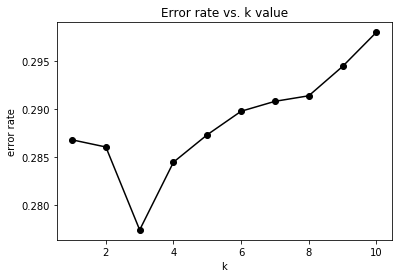

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, 11), knn_errors, 'ko-')
plt.xlabel('k')
plt.ylabel('error rate')
plt.title('Error rate vs. k value')

As seen from the graph, the model is optimized when k is equal to 3, producing an error rate of about 0.275. This means that a house's price can be best predicted by 3 houses that are closest to it in features.

### <div id="lr">Linear Regression</div>

We tried to use linear regression to estimate the price of the house listings.

Firstly, in the feature engineering stage, we design several features and test their correlation with the home price in our training data. The features we used including square feet, poverty rate, education attainment, year built and amenity index which is calculated by the sum of number of restaurants nearly scaled by their average rating and the number of stores scaled by their average rating. We tested severals ways to construct the amenity index, however, the result was less than satisfying. The best we could get use the fourmula described above and the correlation coefficent against the price per sqft is about 0.25.

In [ ]:
# TODO: help me attach the picture of price per sqft against amenity index

We first use year built, amenity index, poverty rate and education attainment to predict the price per sqft. We use k-fold validation with mean absolute percentage error to test the performance. As a result, the linear model achieved a mean absolute percentage error of 32.289%.

With the price per sqft prediction, we multiply the prediction array with the square feet data of each listing and get the final prediction regarding the total price. The prediction had a mean abosolute percentage error of 32.269%

In [1]:
class LinearReg:
    ...
    def preprocessing2(self, df):
        df['neighbor_amenity_index'] = list(map(self.neighbor_amenity_index, df['restaurant_count'], df['restaurant_rating'], df['restaurant_price'],
			df['shopping_count'], df['shopping_rating'], df['shopping_price']))
		df['newness'] = df["date"].apply(lambda d: (d - 1850)**2)
		df["price_per_sqft"] = list(map(lambda x,y : float(x)/y, df['price'], df['sqft']))
		X = np.array([df['neighbor_amenity_index'], df['newness'], 
			df['median_household_income'], df['education_attainment']]).T
		y = df["price_per_sqft"].values.copy()
		return (X, y)
    ...
    def regression_against_price_per_sqft(self):
		df = self.get_data()
		X, y = self.preprocessing2(df)
		n,params = X.shape
		blocks = self.split_data(n, 10)
		error = self.k_folds_validation(X, y, blocks)
		print(error)
		model1 = self.train(X, y)

		sqfts = self.get_sqft(df)
		_, price = self.getPricePerSqftData(df)
		y_layer1 = model1.predict(X)
		y_layer1 = y_layer1.reshape((len(y_layer1), 1))
		y_pred = np.multiply(y_layer1, sqfts)
		error = self.error(price, y_pred)
		print(error)


TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-1-43affdc8f175>, line 4)

In the second try, we fed all the features mentioned above together with the square feet into a linear regressor to predict the total price. With k-fold validation, the mean absoluate percentage error increased to 38%. This is expected because during our feature engineering phase, we found that most of the features we have are more strongly correlated with price per sqft than with price. For instance, the correlation coefficient of price per sqft against newness (newness = (data built - 1850) ^ 2) is 0.501 while price against newness is 0.401

In [ ]:
# TODO: help me attach two figures here. Price_per_sqft against newness and price against newness

The result, 32.269%, is much better than the benchmark. However, the linear regressor performed worse than k-nearest neighbor. This is understandable because although we tried to use amenity index and neighborhood data to replace the location information of the listing, there are still features we cannot cover, for instance, the view of the house plays an important part but it is hard to generate this feature automatically in a large scale.

### <div id="nn">Neural Network</div>

The last model we used was a neural network with two hidden layers, implemented using keras. First, we thought about whether to categorize the label into ranges (< \$80,000, \$80,000 - \$100,000, etc) or leave it as continuous. Since we have used a categorizing neural network in the deep learning section of homework 5, we decided to challenge ourselves a little and leave the output as continuous. Ideally, we would like the nodes in the hidden layer to learn different aspects about the training data. For example, a certain block might have houses that are more expensive. When a testing entries provides the network with a house that is in that block, a certain node would be triggered and return a higher price as the final answer. Since with 2 hidden layers, the network is no longer linear, so we decided to use the coordinates of a house instead of features of a neighborhood.

In [2]:
from src.neural_network import Network

nn = Network('data/full_data_randomized.csv', ['long', 'lat', 'sqft', 'beds', 'baths', 'date'], 'price')
nn.train()
print(nn.validate())

0.351087720057


Although the performance of the network is not as good as we had hoped for, we think that it is justified. First of all, we only have about 4000 collected entries and only 80% of those are used to train the network. With only about 100 houses collected per zip code, it would be very hard for the network to learn a lot of the underlying information. Moreover, it is difficult for us to reason about how many underlying features the network can pick up on. Even though we have tried adjusting the number of hidden nodes and the number of hidden layers, it is hard for us to try out more structures that could produce better estimates.

## Analysis Of The Results:

Overall, we think that the project is a success. We managed to create a model that can predict house prices with about 27% error, which is far less than the 63% gotten from the mean predictor. Just as we thought, k nearest neighbors had the highest accuracy. In conclusion, each model had its own advantages and disadvantages. Linear regression was simple to visualize but it was hard to take into account other useful features. K nearest neighbors gave the highest accuracy but was by far the slowest for predicting. The neural network was very easy to implement, but it is difficult to explain why some houses are more expensive.

## Improvements:

There are many improvements we can make to our project and we will discuss a few important ones below.

1. We can collect more features for each house and more houses overall. Due to some time constraints, we only collected data on about 4000 houses. With more features and more data, all of our models will be able to predict at higher accuracies, especially the linear regression model and the neural network.
2. We can eliminate outliers from our training data. We thought of using the linear regression to detect outliers in the training example and eliminating them before feeding the training data into the other models, but we felt like this was cheating, as the other models use similar features. We could look into other ways of detecting outliers and eliminating them. This will improve the accracies of all of our models as well.
3. Since homes.com did not provide accurate house types, we assumed that all of the listings are houses and not apartments, townhouses, duplexes, etc. We could come up with a way of determining whether an address is of an apartment or a house and we think that this could increase our accuracies significantly. However, given our limited amount of data, further spliting them into different house types would result in too little data for each house type.

## Expanding The Project:

Most of the models we implemented are not confined to certain features. In the future, we hope to expand our project to predict house prices nationwide. All we need is more data and more features!